# DevOps Engineer Interview Project
**Author : Felix Yuzhou Sun**

## 0. Introduction

In the context of financial analysis, accurately extracting Earnings Per Share (EPS) data from regulatory filings is essential for investors, analysts, and financial professionals. This task, often complicated by the diverse formats and structures of financial documents, requires a robust and adaptable parsing solution.

This project involves developing a parser to extract EPS data from SEC EDGAR filings in HTML format, as part of an assessment for a DevOps Engineer Interview at Trexquant Investment LP. The primary objective is to create a versatile parser that can handle various filing formats, systematically extract the latest quarterly EPS for each company, and present this data in a structured CSV format.

The development and testing of this parser are grounded in the analysis of 50 provided HTML files, focusing on identifying common patterns, handling variations, and ensuring the parser's adaptability to unseen document formats. The outcome of this project will be a reliable tool capable of facilitating informed financial decision-making through accurate data extraction.

## 1. Understanding the data

To build a robust parser, we will meticulously analyze the 50 training filings, identifying the common patterns and locations where EPS data is typically reported. This analysis will encompass recognizing keywords, table structures, and contextual cues that signal the presence of relevant information. We will also pay close attention to potential inconsistencies and edge cases, ensuring our parser's accuracy and adaptability across different EDGAR filings.

In [ ]:
# Set Up Environment
%pip install beautifulsoup4 lxml pandas html5lib
%pip install spacy
%pip install nltk

In [ ]:
!python -m spacy download en_core_web_sm

In [1]:
import os
from bs4 import BeautifulSoup
import pandas as pd
import re
from collections import defaultdict

In [2]:
# Check the html data
current_directory = os.getcwd()
data_directory  = 'Training_Filings'
data_path = os.path.join(current_directory, data_directory)
print(f"Current working directory: {current_directory}")
print(data_path)

# Verify the data size
html_files = [f for f in os.listdir(data_path) if f.endswith('.html')]
# Total number of files
total_files = len(html_files)
print(f"Found {total_files} HTML files.")

Current working directory: /home/bbharbinger/Projects/EPS_Paser
/home/bbharbinger/Projects/EPS_Paser/Training_Filings
Found 50 HTML files.


### A. Tag Analysis

In [3]:
%%time
# Dictionary to hold the number of files in which each tag appears
tag_file_count = defaultdict(int)

# Iterate through all files and count tags
for file in html_files:
    filepath = os.path.join(data_path, file)
    
    with open(filepath, 'r', encoding='utf-8') as html_file:
        soup = BeautifulSoup(html_file, 'html.parser')
        
        # Extract unique tags from the current file
        unique_tags_in_file = set(tag.name for tag in soup.find_all(True))
        
        # Update the count of each tag, but only once per file
        for tag in unique_tags_in_file:
            tag_file_count[tag] += 1

# Calculate the percentage of files in which each tag appears
tag_percentage = {tag: (count / total_files) * 100 for tag, count in tag_file_count.items()}

# Sort the tags by percentage in descending order
sorted_tags = sorted(tag_percentage.items(), key=lambda item: item[1], reverse=True)

# Print results
print(f"{'Tag':<15}{'Files':<10}{'Percentage':<10}")
for tag, percentage in sorted_tags:
    print(f"{tag:<15}{tag_file_count[tag]:<10}{percentage:<10.2f}%")

Tag            Files     Percentage
tr             50        100.00    %
type           50        100.00    %
document       50        100.00    %
html           50        100.00    %
sequence       50        100.00    %
font           50        100.00    %
table          50        100.00    %
filename       50        100.00    %
text           50        100.00    %
td             50        100.00    %
body           50        100.00    %
div            49        98.00     %
title          49        98.00     %
description    49        98.00     %
br             46        92.00     %
hr             42        84.00     %
sup            38        76.00     %
img            36        72.00     %
a              26        52.00     %
p              23        46.00     %
b              14        28.00     %
u              13        26.00     %
i              8         16.00     %
ul             4         8.00      %
li             4         8.00      %
center         4         8.00      %
h2

#### Tag analysis results

| Tag 1         | Files | Percentage | Tag 2         | Files | Percentage |
|---------------|-------|------------|---------------|-------|------------|
| body          | 50    | 100.00%    | br            | 46    | 92.00%     |
| document      | 50    | 100.00%    | hr            | 42    | 84.00%     |
| filename      | 50    | 100.00%    | sup           | 38    | 76.00%     |
| font          | 50    | 100.00%    | img           | 36    | 72.00%     |
| html          | 50    | 100.00%    | a             | 26    | 52.00%     |
| sequence      | 50    | 100.00%    | p             | 23    | 46.00%     |
| table         | 50    | 100.00%    | b             | 14    | 28.00%     |
| td            | 50    | 100.00%    | u             | 13    | 26.00%     |
| text          | 50    | 100.00%    | i             | 8     | 16.00%     |
| tr            | 50    | 100.00%    | ul            | 4     | 8.00%      |
| type          | 50    | 100.00%    | li            | 4     | 8.00%      |
| title         | 49    | 98.00%     | center        | 4     | 8.00%      |
| description   | 49    | 98.00%     | h1            | 3     | 6.00%      |
| div           | 49    | 98.00%     | h2            | 3     | 6.00%      |
| em            | 1     | 2.00%      | meta          | 2     | 4.00%      |
| strike        | 1     | 2.00%      | strong        | 1     | 2.00%      |



#### Insights from the Tag Analysis


1. **Core Tags (`table`, `td`, `tr`)**:
   - **High Occurrence (100%)**: Tags like `<table>`, `<td>`, `<tr>`, and related tags appear in every document. This indicates that EPS data, which is typically presented in tabular format, is consistently structured within tables. Therefore, the parser should primarily focus on searching within `<table>` tags to locate EPS values.

2. **Document Structure (`html`, `body`, `title`)**:
   - **High Occurrence (100%)**: Tags such as `<html>`, `<body>`, and `<title>` are present in every file, indicating that all documents follow a well-defined HTML structure. The `<title>` tag, which often contains the document's title, might give context (e.g., the company name or report type) that could help identify relevant sections of the document.

3. **Financial Data Tags (`sup`, `sub`)**:
   - **Moderate Occurrence (76%, 84%)**: Tags like `<sup>` (often used for superscripts like footnotes) might be associated with small notations beside financial data, including EPS figures. These tags are important for handling any associated footnotes or references that could alter the interpretation of the EPS data (e.g., adjustments for extraordinary items).
   
4. **Formatting Tags (`font`, `br`, `hr`, `b`)**:
   - **High to Moderate Occurrence**: Tags like `<font>`, `<br>`, and `<b>` indicate that the documents use various formatting styles to highlight or structure the data. Bold tags (`<b>`) often emphasize key financial metrics, including EPS.

### B. Recognize "Earnings Per Share" patterms

"Earnings Per Share" (EPS) might appear in various forms, including abbreviations, acronyms, or even partially spaced out versions like "E...P...S...". We need to capture not just standard forms like "EPS" or "Earnings Per Share," but also non-standard forms like "E... P... S..." or "earnings p/share." 

#### High-Level Methodology:

1. **Isolate Relevant Sections**:
   - **Goal**: Focus on parts of the document that are likely to contain EPS-related information, primarily the tables.
   - **Method**: Extract all `<table>` elements from each HTML file since these sections are structured and likely contain financial data.

2. **Tokenize Content**:
   - **Goal**: Break down the table content into manageable pieces (tokens) to identify relevant information.
   - **Method**: Treat each cell within a table (`<td>` or `<th>`) as a token. These tokens will contain words or phrases that can be analyzed individually.

3. **Pattern Matching**:
   - **Goal**: Identify tokens that are likely to be related to EPS by searching for specific keywords or phrases.
   - **Method**: Look for the presence of certain key components within each token, such as:
     - **"earn"**: Captures "earnings," "earn," "earning," etc.
     - **"per"**: Relevant for identifying "per share."
     - **"share"**: Specifically targets mentions of shares.
     - **"loss"**: Captures contexts like "net income (loss)" or "earnings (loss) per share."

4. **Contextual Analysis**:
   - **Goal**: Ensure the identified tokens are relevant to EPS and not unrelated financial terms (like "expenses").
   - **Method**: Consider the context in which these tokens appear. This involves checking the neighboring tokens or phrases to confirm they relate to EPS (e.g., "net income (loss)" or "GAAP earnings per share").

5. **Extraction and Aggregation**:
   - **Goal**: Extract the relevant phrases or terms and aggregate them across all documents.
   - **Method**: Combine tokens that are identified as related to EPS into complete phrases, and track their occurrences across all files.

6. **Generalization**:
   - **Goal**: Develop a robust approach that can handle variations in how EPS is presented across different documents.
   - **Method**: Use the patterns identified to create generalized rules that can be applied to other datasets.




         

#### Exploratory Text Mining

In [4]:
import os
from bs4 import BeautifulSoup
from spacy.matcher import Matcher
from collections import defaultdict
from tqdm import tqdm

**We start with finding out tokens with "per" and "share", then try to narrow down the patterm.**

In [5]:
# Function to extract tables from HTML content
def extract_tables(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    return soup.find_all('table')

# Function to tokenize content from a table
def tokenize_table(table):
    tokens = []
    for row in table.find_all('tr'):
        for cell in row.find_all(['td', 'th']):
            tokens.append(cell.get_text(strip=True).lower())
    return tokens

# Simplified function to match tokens that contain "per" and "share"
def match_eps_patterns(tokens):
    eps_related_phrases = []
    for token in tokens:
        if 'per' in token and 'share' in token or 'eps' in token:  # Only check for "per" and "share" or EPS
            eps_related_phrases.append(token)
    return eps_related_phrases

# Function to filter out irrelevant phrases
def filter_relevant_phrases(phrases):
    relevant_phrases = []
    for phrase in phrases:
        # Additional filtering logic to remove irrelevant terms
        if 'expenses' not in phrase and 'expectations' not in phrase:
            relevant_phrases.append(phrase)
    return relevant_phrases

# Function to aggregate EPS-related data across all HTML files
def aggregate_eps_data(html_files):
    eps_data = defaultdict(set)
    files_with_matches = 0  # Counter for files with at least one match

    for file in tqdm(html_files, desc="Processing files"):
        filepath = os.path.join(data_path, file)
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()
            tables = extract_tables(content)
            file_has_match = False  # Track if this file has at least one match

            for table in tables:
                tokens = tokenize_table(table)
                eps_phrases = match_eps_patterns(tokens)
                relevant_phrases = filter_relevant_phrases(eps_phrases)

                if relevant_phrases:
                    file_has_match = True
                    eps_data[file].update(relevant_phrases)

            if file_has_match:
                files_with_matches += 1  # Increment counter if a match is found

    return eps_data, files_with_matches

In [6]:
%%time
# Run the aggregation function and print the results
eps_data, files_with_matches = aggregate_eps_data(html_files)

# Print the number of files with at least one match
total_files = len(html_files)
print(f"\nNumber of files with at least one match: {files_with_matches} out of {total_files}")


Processing files: 100%|██████████| 50/50 [00:05<00:00,  8.37it/s]


Number of files with at least one match: 50 out of 50
CPU times: user 5.88 s, sys: 99.9 ms, total: 5.98 s
Wall time: 5.98 s


In [7]:
# Print the set of EPS candidates for each file
for file, eps_set in eps_data.items():
    print(f"\nFile: {file}")
    print("EPS-related Phrases:")
    for phrase in eps_set:
        print(f"  - {phrase}")


File: 0000875320-20-000014.html
EPS-related Phrases:
  - shares used in diluted per share calculations:
  - (in millions, except per share amounts)
  - shares used in per share calculations:
  - net income per common share:
  - net income per diluted common share:
  - non-gaap net income per share - diluted
  - gaap net income per share - diluted

File: 0001165002-20-000083.html
EPS-related Phrases:
  - dividends declared per share
  - economic eps
  - earnings per share:

File: 0001423689-20-000040.html
EPS-related Phrases:
  - tangible net book value per common share excludes preferred stock liquidation preference and goodwill.
  - comprehensive income (loss) per common share - diluted
  - net spread and dollar roll income, excluding "catch-up" premium amortization, per common share - basic
  - excludes$(0.44)per common share of estimated "catch-up" premium amortizationcostdue to change in projected constant prepayment rate ("cpr") estimates
  - dividends declared per common share
 

#### Insights from the outputs

**As the information above shows:**

- EPS-related phrases often contain a mix of short, meaningful tokens (like "earnings per share").

- Longer, descriptive sentences are not directly useful for locating EPS values.

<br>

**Next Steps:**

- **Plotting a Histogram**: We'll create a histogram to visualize the distribution of token lengths. This will help us determine a logical cut-off point for filtering.

- **Applying the Filter**: Once the cut-off point is set up, we'll filter out tokens that exceed this length, focusing only on the shorter, more relevant tokens.



In [8]:
token_lengths = []

# Calculate the length of each phrase and store it in the list
for eps_set in eps_data.values():
    for phrase in eps_set:
        token_lengths.append(len(phrase))


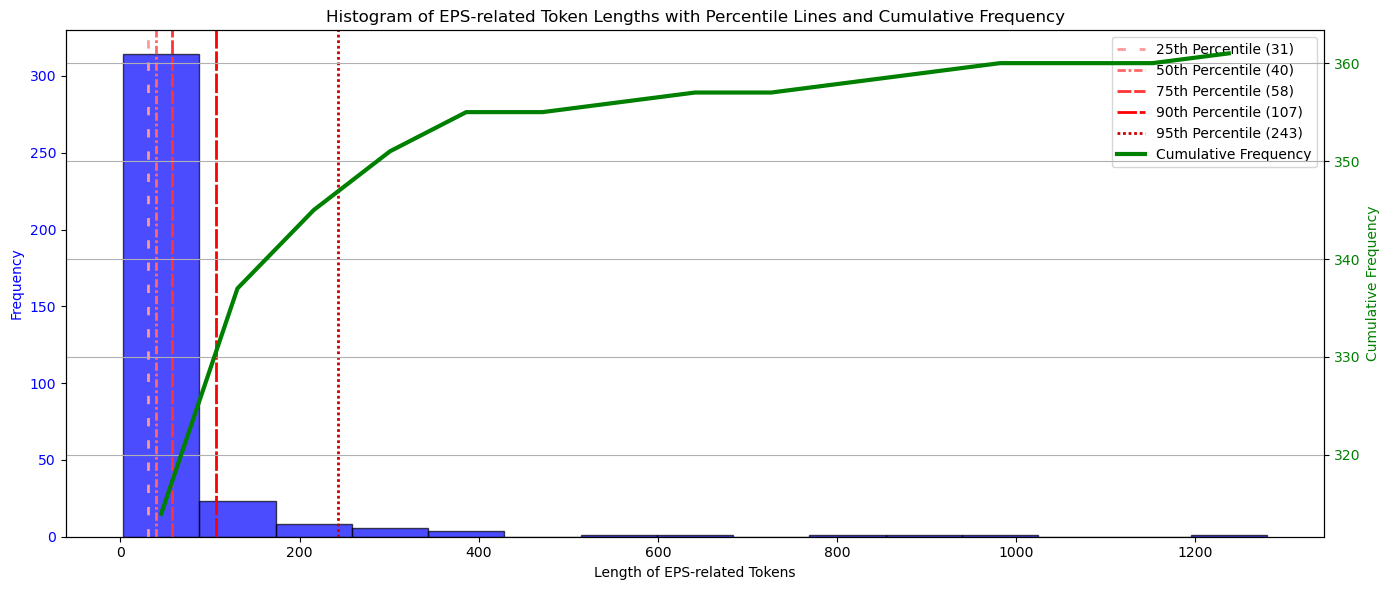

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the percentiles
percentiles = [25, 50, 75, 90, 95]
percentile_values = np.percentile(token_lengths, percentiles)

# Create the histogram and cumulative frequency
hist, bins = np.histogram(token_lengths, bins=15)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
cumulative_freq = np.cumsum(hist)

# Define different line styles and colors for each percentile
line_styles = [(0, (3, 5)), (0, (3, 1, 1, 1)), (0, (5, 1)), (0, (7, 1)), (0, (1, 1))]
colors = ['#ff9999', '#ff6666', '#ff3333', '#ff0000', '#cc0000']

# Create the figure and the first y-axis for the histogram
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.bar(bin_centers, hist, width=bins[1] - bins[0], color='blue', alpha=0.7, edgecolor='black')
ax1.set_xlabel("Length of EPS-related Tokens")
ax1.set_ylabel("Frequency", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot percentile lines with different line styles and colors
for perc, value, style, color in zip(percentiles, percentile_values, line_styles, colors):
    ax1.axvline(value, color=color, linestyle=style, linewidth=2, label=f'{perc}th Percentile ({int(value)})')

# Create a secondary y-axis for the cumulative frequency
ax2 = ax1.twinx()
ax2.plot(bin_centers, cumulative_freq, color='green', linestyle='-', linewidth=3, label="Cumulative Frequency")
ax2.set_ylabel("Cumulative Frequency", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add a legend and move it to the top right
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title("Histogram of EPS-related Token Lengths with Percentile Lines and Cumulative Frequency")

fig.tight_layout()  # Adjust the layout to accommodate both y-axes
plt.grid(True)
plt.show()


#### Insights from the Token Length Analysis

- **Percentile-Based Analysis**: The 25th percentile is at 32 characters, the 50th percentile at 40 characters, and the 75th percentile at 59 characters. This indicates that 75% of the relevant tokens are within 59 characters.

- **Potential Cut-off Point**: Based on the percentile analysis and the cumulative frequency curve, a reasonable cut-off point for filtering relevant EPS-related tokens might be around 100 characters. This cut-off would capture about 90% of the relevant tokens while excluding the longer, less relevant descriptive sentences.

In [10]:
# Define the cut-off length
cut_off_length = 100

# Initialize counters for total before and after filtering
total_before_filtering = 0
total_after_filtering = 0

# Initialize dictionary to store the filtered EPS data
filtered_eps_data = {}

# Iterate over the files and apply the filtering
for file, eps_set in eps_data.items():
    before_count = len(eps_set)  # Count before filtering
    filtered_eps_set = {phrase for phrase in eps_set if len(phrase) <= cut_off_length}
    after_count = len(filtered_eps_set)  # Count after filtering
    
    # Store the filtered data
    filtered_eps_data[file] = filtered_eps_set
    
    # Update total counters
    total_before_filtering += before_count
    total_after_filtering += after_count
    
    # Print only the filtered EPS-related phrases
    print(f"File: {file}")
    print(f"  EPS-related phrases after filtering ({after_count}):")
    for phrase in filtered_eps_set:
        print(f"    - {phrase}")
    print("")  # Add an empty line for better readability

# Calculate the total difference
total_difference = total_before_filtering - total_after_filtering

# Print the overall results
print("Overall Summary:")
print(f"Total number of EPS-related phrases before filtering: {total_before_filtering}")
print(f"Total number of EPS-related phrases after filtering: {total_after_filtering}")
print(f"Total difference (removed): {total_difference}")



File: 0000875320-20-000014.html
  EPS-related phrases after filtering (7):
    - (in millions, except per share amounts)
    - gaap net income per share - diluted
    - shares used in per share calculations:
    - net income per common share:
    - net income per diluted common share:
    - non-gaap net income per share - diluted
    - shares used in diluted per share calculations:

File: 0001165002-20-000083.html
  EPS-related phrases after filtering (3):
    - dividends declared per share
    - economic eps
    - earnings per share:

File: 0001423689-20-000040.html
  EPS-related phrases after filtering (18):
    - net spread and dollar roll income per common share - diluted
    - ending cumulative non-deductible net capital loss per common share
    - comprehensive income (loss) per common share - diluted
    - decreased$(4.04)per common share, or-22.9%, from$17.66per common share as ofdecember 31, 2019
    - net income (loss) per common share - diluted
    - dividends declared per c

#### Keywords Analysis

**By filtering out common words and symbols, we can focus on key financial terms that are likely to indicate the presence of EPS data.**

- **Stopword Removal**: We remove common English words (like "the", "in", "and") that do not contribute meaningful information to the identification of EPS-related phrases. This ensures that our analysis focuses on more specific terms.

- **Non-Alphabetic Character Filtering**: By cleaning out non-alphabetic characters, we standardize the words and prevent variations like "(loss)" and "loss" from being treated differently. This makes the word counts more accurate and meaningful.

- **Word Count Aggregation**: We then aggregate the occurrence of key financial terms across all files. This helps us identify the most frequently used words that are directly related to EPS data.

In [11]:
import nltk
nltk.__version__
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bbharbinger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
from collections import Counter
import re
from nltk.corpus import stopwords

# Function to tokenize phrases into words
def tokenize(phrase):
    return phrase.lower().split()

# Load NLTK's set of stopwords
nltk_stopwords = set(stopwords.words('english'))

# Define additional excluded words (including "per", "share", and "eps")
excluded_words = set(["per", "share", "eps"]) | nltk_stopwords

# Initialize a counter for the words
word_count = Counter()

# Process each file's phrases
for phrases in filtered_eps_data.values():
    unique_words_in_file = set()  # Set to collect unique words per file
    for phrase in phrases:
        # Clean each word in the phrase
        cleaned_words = [re.sub(r'[^a-zA-Z]', '', word).lower() for word in phrase.split()]
        # Filter out empty strings and excluded words (stopwords)
        cleaned_words = [word for word in cleaned_words if word and word not in excluded_words]
        # Update the set of unique words for the current file
        unique_words_in_file.update(cleaned_words)
    
    # Update the word count with the unique words from the file
    word_count.update(unique_words_in_file)

# Print the total number of unique words
print(f"Total Unique Words {len(word_count)}")


Total Unique Words 153


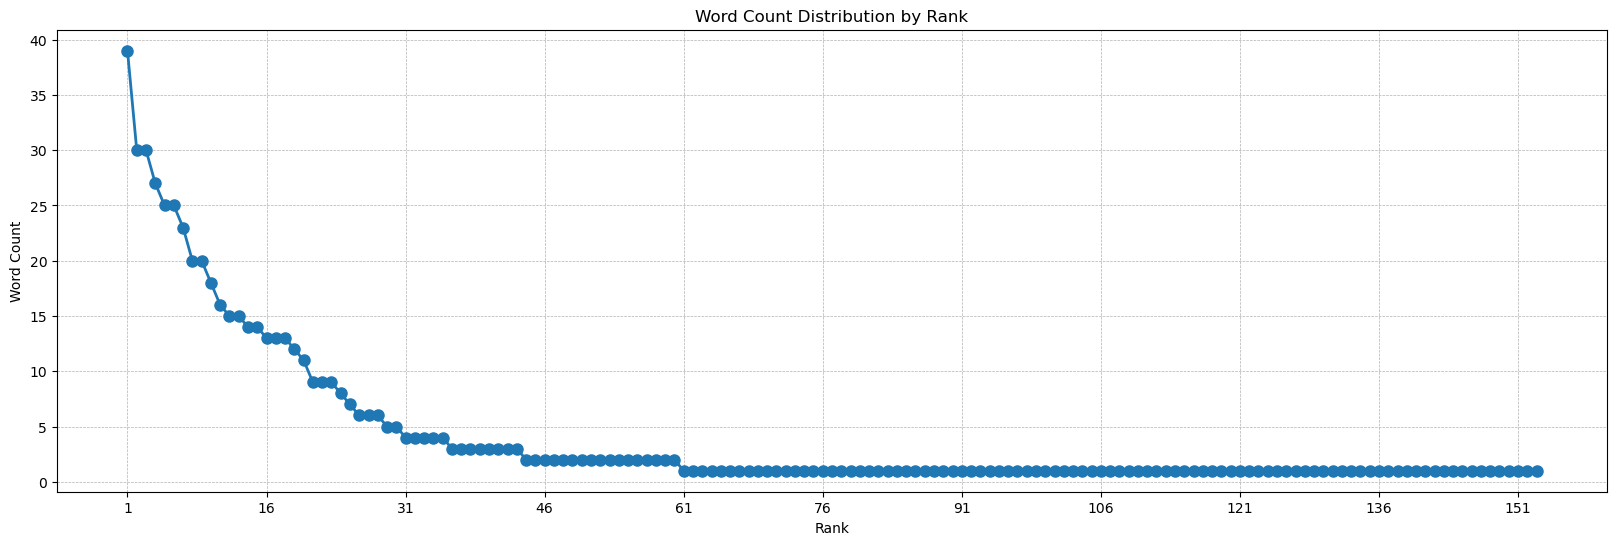

In [13]:
# Sorting the word counts in descending order
sorted_counts = sorted(word_count.values(), reverse=True)

# Plotting the histogram of word counts by rank
plt.figure(figsize=(20, 6))
plt.plot(range(1, len(sorted_counts) + 1), sorted_counts, marker='o', markersize=8, linestyle='-', linewidth=2)

# Adding grid lines
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.title('Word Count Distribution by Rank')
plt.xlabel('Rank')
plt.ylabel('Word Count')
plt.xticks(range(1, len(sorted_counts) + 1, max(1, len(sorted_counts) // 10)))  # Adjust x-ticks for clarity
plt.show()

- **Steep Initial Drop**: The plot shows a steep drop at the beginning, indicating that a few words have very high counts across the files, which suggests these are likely the most significant or common words related to EPS data.

- **Long Tail**: After the initial drop, the word counts level off, forming a long tail with many words having low counts. These words may be less relevant or could represent noise in the data.

**A reasonable approach could be using "elbow method"--to select the top words until the word count drops significantly. Based on the plot, a good starting point might be to select the top 16 - 20 words.**

In [14]:
# Display the top 20 words
for word, count in word_count.most_common(20):
    print(f"  {word}: {count}")


  diluted: 39
  except: 30
  earnings: 30
  net: 27
  common: 25
  basic: 25
  income: 23
  data: 20
  loss: 20
  thousands: 18
  amounts: 16
  shares: 15
  adjusted: 15
  value: 14
  book: 14
  nongaap: 13
  millions: 13
  dividends: 13
  tangible: 12
  gaap: 11


##### Keywords Analysis Results

| Rank 1   | Word 1          | Count 1    | Rank 2   | Word 2          | Count 2    |
|----------|-----------------|------------|----------|-----------------|------------|
| <1>      | diluted         | 39         | <11>     | amounts         | 16         |
| <2>      | except          | 30         | <12>     | shares          | 15         |
| <3>      | earnings        | 30         | <13>     | adjusted        | 15         |
| <4>      | net             | 27         | <14>     | value           | 14         |
| <5>      | common          | 25         | <15>     | book            | 14         |
| <6>      | basic           | 25         | <16>     | millions        | 13         |
| <7>      | income          | 23         | <17>     | nongaap         | 13         |
| <8>      | loss            | 20         | <18>     | dividends       | 13         |
| <9>      | data            | 20         | <19>     | tangible        | 12         |
| <10>     | thousands       | 18         | <20>     | gaap            | 11         |

**Key Financial Terms**: Frequent words like "basic", "diluted," "earnings," "net," "income," and "loss" suggest the documents focus heavily on EPS-related metrics.

In [15]:
# Calculate the total number of terms before filtering
total_terms_before = sum(len(phrases) for phrases in filtered_eps_data.values())

# Define key terms with regex patterns
key_terms_patterns = [
    r'\beps\b',
    r'\bincome\b',
    r'\bloss\b',
    r'\bearn\w*\b',   # Matches "earn", "earning", "earnings", etc.
    r'\bdiluted\b',
    r'\bbasic\b'
]

# Function to check if any key term pattern matches in a phrase
def matches_key_terms(phrase, patterns):
    return any(re.search(pattern, phrase.lower()) for pattern in patterns)

In [16]:
# Further filter the filtered_eps_data using regex for variations
further_filtered_eps_data = {}

for file, phrases in filtered_eps_data.items():
    filtered_phrases = set()
    for phrase in phrases:
        # Keep the phrase if it matches any key term pattern
        if matches_key_terms(phrase, key_terms_patterns):
            filtered_phrases.add(phrase)
    
    # Update the dictionary with further filtered phrases
    further_filtered_eps_data[file] = filtered_phrases

# Calculate the total number of terms after filtering
total_terms_after = sum(len(phrases) for phrases in further_filtered_eps_data.values())

# Calculate the difference
diff = total_terms_before - total_terms_after

# Output the results
print(f"Total number of terms before filtering: {total_terms_before}")
print(f"Total number of terms after filtering: {total_terms_after}")
print(f"Difference: {diff}")

Total number of terms before filtering: 318
Total number of terms after filtering: 193
Difference: 125


In [17]:
# Print the filtered phrases for each file
for file, phrases in further_filtered_eps_data.items():
    print(f"\nFile: {file}")
    for phrase in phrases:
        print(f"  - {phrase}")


File: 0000875320-20-000014.html
  - gaap net income per share - diluted
  - net income per common share:
  - net income per diluted common share:
  - non-gaap net income per share - diluted
  - shares used in diluted per share calculations:

File: 0001165002-20-000083.html
  - economic eps
  - earnings per share:

File: 0001423689-20-000040.html
  - net spread and dollar roll income per common share - diluted
  - ending cumulative non-deductible net capital loss per common share
  - comprehensive income (loss) per common share - diluted
  - net income (loss) per common share - diluted
  - net spread and dollar roll income per common share - basic
  - estimated reit taxable income per common share - diluted
  - comprehensive income (loss) per common share - basic
  - estimated reit taxable income per common share - basic
  - net income (loss) per common share - basic

File: 0001299709-20-000078.html
  - adjusted eps (non-gaap)
  - diluted eps
  - adjusted eps (non-gaap)1

File: 0000846

#### Summary of Insights

1. **Identified EPS-Related Phrases**:
   - The filtering process effectively identified numerous phrases related to Earnings Per Share (EPS) across multiple HTML filings. These phrases include terms like "net income per share," "diluted EPS," and "basic earnings per share," reflecting the different ways companies report EPS data.

2. **Coverage Across Files**:
   - The extraction process successfully spanned a wide range of files, demonstrating that the filtering criteria were broad enough to capture relevant phrases from various sources.

#### Limitations:

1. **Inclusion of Irrelevant Phrases**:
   - Despite the filtering, many phrases that are not directly relevant to EPS calculations remain in the results. For instance, phrases like "shares used in diluted per share calculations" may not provide the precise EPS values we aim to extract.

2. **Over-Inclusiveness**:
   - The broad criteria used for filtering allowed for the capture of a wide array of phrases, some of which may not directly relate to EPS figures but instead to peripheral information such as share counts or reconciliation of GAAP and non-GAAP measures.

3. **Ambiguity in Some Terms**:
   - Certain phrases, while containing key terms like "earnings" or "share," may refer to different financial metrics or calculations that are not relevant to the core EPS value we seek. This introduces ambiguity and can dilute the effectiveness of the filtering process.

4. **Complexity in Non-GAAP Reporting**:
   - The presence of non-GAAP terms like "adjusted EPS" or "economic EPS" adds complexity, as these metrics may vary significantly across filings and may not always align with standard EPS calculations.

<br>

**Given these limitations, the next step involves a more structured approach to extracting relevant EPS data by analyzing the HTML file's underlying data structure.**


### C. Data Structure Analysis

To improve the accuracy and relevance of our EPS data extraction, it's essential to understand the underlying structure of the HTML documents. By analyzing the HTML structure, we can identify consistent patterns and elements that house the desired financial data. This analysis will allow us to develop a more targeted approach to extract EPS values and associated terms, aligning our method with the key requirements such as prioritizing basic EPS, handling multiple EPS entries, and correctly interpreting negative values.


#### Transform Tables into Structured Data

The first step in our data structure analysis involves transforming the tabular content within the HTML files into a structured data format. This process will enable us to systematically analyze and extract relevant EPS-related information. 

1. **Identify and Extract Tables**: 
   - Use BeautifulSoup to locate all `<table>` elements within each HTML file. These tables often contain financial data presented in a structured format.

2. **Parse Table Content**:
   - For each table, extract the content of rows (`<tr>`) and cells (`<td>` or `<th>`), converting them into a structured format like lists or dictionaries. This allows for easy manipulation and filtering of the data.

3. **Tokenize and Normalize Data**:
   - Tokenize the text within each cell to ensure that the content is in a consistent, lowercased format. This will help in matching terms like "EPS" or "earnings per share" across different filings.

4. **Structure the Data**:
   - Convert the parsed table data into a more structured format, such as a list of dictionaries, where each dictionary represents a row in the table, with keys corresponding to the column headers.


In [18]:
from bs4 import BeautifulSoup
import pandas as pd
import html5lib

# Verify the data size
html_files = [f for f in os.listdir(data_path) if f.endswith('.html')]
total_files = len(html_files)
print(f"Found {total_files} HTML files.")

Found 50 HTML files.


In [33]:
# Define the word patterns
primary_keywords = ["eps"]
secondary_keywords = ["per", "share"]
conditional_keywords = ["earn", "earning", "earnings", "net", "income", "loss"]

# Function to check if a table contains the required patterns
def table_matches_criteria(table):
    contains_eps = False
    contains_per_share = False
    contains_conditional = False
    
    for row in table.find_all('tr'):
        for cell in row.find_all(['td', 'th']):
            cell_text = cell.get_text(strip=True).lower()
            
            # Check for primary keywords ("eps")
            if any(keyword in cell_text for keyword in primary_keywords):
                contains_eps = True
                
            # Check for secondary keywords ("per" and "share")
            if all(keyword in cell_text for keyword in secondary_keywords):
                contains_per_share = True
                
            # Check for conditional keywords ("earn", "net", "income", "loss")
            if any(keyword in cell_text for keyword in conditional_keywords):
                contains_conditional = True
                
            # If all conditions are met, no need to check further
            if contains_eps or (contains_per_share and contains_conditional):
                return True

    return False

**Check the first html files**

In [38]:
# Process each HTML file
for file_name in html_files[:2]:
    file_path = os.path.join(data_path, file_name)
    
    # Define the name of the file
    current_file_name = os.path.splitext(file_name)[0]  # Strip off the extension for simplicity
    
    # Open and read the HTML file
    with open(file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()
    
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(html_content, 'lxml')
    
    # Find all tables in the HTML
    tables = soup.find_all('table')
    
    # Print the name of the current file being processed
    print(f"Processing file: {current_file_name}")
    
    # Loop through the tables and filter based on keywords
    for i, table in enumerate(tables):
        if table_matches_criteria(table):
            df = pd.read_html(str(table))[0]
            
            # Print the table index and dataframe
            print(f"\nTable {i+1} (Keyword Match):")
            display(df)
    
    print("\n" + "="*80 + "\n")  # Separator between files

Processing file: 0000875320-20-000014

Table 1 (Keyword Match):


,0,1,2,3,4,5,6,7,8,9,10,11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,"Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,",NaN,%
3,NaN,2020,2020,2020,2020,NaN,2019,2019,2019,2019,NaN,Change
4,NaN,"(in millions, except per share amounts)","(in millions, except per share amounts)","(in millions, except per share amounts)","(in millions, except per share amounts)","(in millions, except per share amounts)","(in millions, except per share amounts)","(in millions, except per share amounts)","(in millions, except per share amounts)","(in millions, except per share amounts)","(in millions, except per share amounts)","(in millions, except per share amounts)"
5,"Product revenues, net",$,1515,NaN,NaN,NaN,$,857,NaN,NaN,NaN,77%
6,TRIKAFTA,$,895,NaN,NaN,NaN,$,—,NaN,NaN,NaN,NaN
7,SYMDEKO/SYMKEVI,$,173,NaN,NaN,NaN,$,320,NaN,NaN,NaN,NaN
8,ORKAMBI,$,234,NaN,NaN,NaN,$,293,NaN,NaN,NaN,NaN
9,KALYDECO,$,213,NaN,NaN,NaN,$,244,NaN,NaN,NaN,NaN



Table 18 (Keyword Match):


,0,1,2,3,4,5,6,7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,"Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,"
3,NaN,2020,2020,2020,NaN,2019,2019,2019
4,Revenues:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"Product revenues, net",$,1515107,NaN,NaN,$,857253,NaN
6,Collaboration and royalty revenues,—,—,NaN,NaN,1182,1182,NaN
7,Total revenues,1515107,1515107,NaN,NaN,858435,858435,NaN
8,Costs and expenses:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Cost of sales,162497,162497,NaN,NaN,95092,95092,NaN



Table 19 (Keyword Match):


,0,1,2,3,4,5,6,7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,"Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,"
3,NaN,2020,2020,2020,NaN,2019,2019,2019
4,GAAP net income,$,602753,NaN,NaN,$,268631,NaN
5,Stock-based compensation expense,115706,115706,NaN,NaN,93791,93791,NaN
6,Decrease (increase) in fair value of strategic...,44870,44870,NaN,NaN,"(43,551","(43,551",)
7,Increase in fair value of contingent considera...,1600,1600,NaN,NaN,—,—,NaN
8,Collaborative revenues and expenses (3),36250,36250,NaN,NaN,6351,6351,NaN
9,Acquisition-related costs (4),2883,2883,NaN,NaN,—,—,NaN




Processing file: 0001165002-20-000083

Table 1 (Keyword Match):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended
2,NaN,NaN,NaN,"March 31, 2020","March 31, 2020","March 31, 2020",NaN,NaN,NaN,"December 31, 2019","December 31, 2019","December 31, 2019",NaN,NaN,NaN,"March 31, 2019","March 31, 2019","March 31, 2019"
3,REVENUES:,REVENUES:,REVENUES:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Advisory fees:,Advisory fees:,Advisory fees:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Asset-based,Asset-based,Asset-based,$,11102,NaN,NaN,NaN,NaN,$,12768,NaN,NaN,NaN,NaN,$,16406,NaN
6,Performance-based,Performance-based,Performance-based,—,—,NaN,NaN,NaN,NaN,310,310,NaN,NaN,NaN,NaN,180,180,NaN
7,Trust fees,Trust fees,Trust fees,5951,5951,NaN,NaN,NaN,NaN,6219,6219,NaN,NaN,NaN,NaN,6539,6539,NaN
8,"Other, net","Other, net","Other, net",(384),(384),NaN,NaN,NaN,NaN,(681),(681),NaN,NaN,NaN,NaN,737,737,NaN
9,Total revenues,Total revenues,Total revenues,16669,16669,NaN,NaN,NaN,NaN,18616,18616,NaN,NaN,NaN,NaN,23862,23862,NaN



Table 4 (Keyword Match):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended,Three Months Ended
2,NaN,NaN,NaN,"March 31, 2020","March 31, 2020","March 31, 2020",NaN,NaN,NaN,"December 31, 2019","December 31, 2019","December 31, 2019",NaN,NaN,NaN,"March 31, 2019","March 31, 2019","March 31, 2019"
3,Net Income,Net Income,Net Income,$,1102,NaN,NaN,NaN,NaN,$,2541,NaN,NaN,NaN,NaN,$,392,NaN
4,Add: Stock-based compensation expense,Add: Stock-based compensation expense,Add: Stock-based compensation expense,2616,2616,NaN,NaN,NaN,NaN,2373,2373,NaN,NaN,NaN,NaN,3252,3252,NaN
5,Add: Intangible amortization,Add: Intangible amortization,Add: Intangible amortization,423,423,NaN,NaN,NaN,NaN,445,445,NaN,NaN,NaN,NaN,413,413,NaN
6,Add: Tax benefit from goodwill amortization,Add: Tax benefit from goodwill amortization,Add: Tax benefit from goodwill amortization,59,59,NaN,NaN,NaN,NaN,59,59,NaN,NaN,NaN,NaN,59,59,NaN
7,Economic Earnings,Economic Earnings,Economic Earnings,$,4200,NaN,NaN,NaN,NaN,$,5418,NaN,NaN,NaN,NaN,$,4116,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Diluted weighted average shares,Diluted weighted average shares,Diluted weighted average shares,8458473,8458473,8458473,NaN,NaN,NaN,8449689,8449689,8449689,NaN,NaN,NaN,8455386,8455386,8455386


#### Insights form the Table Parsing Attempt

##### Observations:
1. **Misalignment of Data:**
   - The table appears to have many "NaN" values, which suggests that the columns are not properly aligned with the corresponding headers.
   - For example, in rows that should contain financial data, such as "GAAP Net income per share - diluted," the values are spread across multiple columns, leading to confusion and loss of information clarity.

2. **Merged or Spanned Cells:**
   - The original HTML table might have used `colspan` or `rowspan` attributes to merge cells, which can cause issues when converting the HTML table directly into a DataFrame. These merged cells can lead to misaligned columns if not handled correctly.

3. **Repetitive Headers:**
   - The presence of repeated headers like "Three Months Ended March 31," across multiple columns could indicate that the data was intended to be grouped but has been split incorrectly across columns.

4. **Non-Numeric Data in Numeric Columns:**
   - Cells intended for numeric values often contain text descriptions (e.g., "(in millions, except per share amounts)"), which can disrupt the alignment and proper interpretation of the data.


##### Implications:
- **Manual Adjustment Required:** Automatic table extraction may require significant manual intervention to correct misalignments and properly organize the data into coherent columns.
- **Challenges with Automated Tools:** The complexity of the table's original formatting, especially with merged cells and non-standard structures, poses challenges for automated extraction tools, which are often not equipped to handle these issues without additional logic.

<br>

### D. Summary

**Given the issues with misaligned tables, using a Large Language Model (LLM) like GPT-3 could help accurately extract the correct Earnings Per Share (EPS) data by leveraging its ability to understand context and complex structures.**

##### Advantages of Using an LLM:
1. **Contextual Understanding:** LLMs can detect relationships between terms like "per share" and "EPS" even when data is misaligned.
2. **Handling Complex Structures:** LLMs can process tables with merged cells or inconsistent formatting, improving accuracy.
3. **Error Reduction:** LLMs can reduce errors by cross-verifying data against recognized financial patterns.
4. **Adaptability:** LLMs can adjust to various document formats, making them versatile for different financial reports.

##### Challenges:
1. **Resource Intensity:** LLMs require significant computational power, which could be a concern with limited resources.
2. **Black-Box Nature:** The lack of transparency in LLM decision-making can make validation difficult.
3. **Need for Fine-Tuning:** Fine-tuning the LLM for specific financial tasks may require additional expertise.
4. **Dependency on Input Quality:** Poorly structured input data can still affect LLM performance.


## Step 2. Implement the Parsing

### A. Implementation Overview for EPS Data Extraction

This project focuses on accurately extracting Earnings Per Share (EPS) data from financial documents, where misaligned or poorly structured tables present significant challenges. We have selected **DistilGPT-2**, a distilled version of GPT-2, as the core model for this task. DistilGPT-2 offers an optimal balance of computational efficiency and contextual understanding, making it well-suited for extracting complex financial data in a local environment.

#### Rationale for Model Selection
1. **Computational Efficiency**
DistilGPT-2 reduces the model size and resource demands by 60% compared to GPT-2 while retaining 97% of its performance. This efficiency is crucial for running the model on standard hardware without sacrificing accuracy.

2. **Contextual Understanding**
The model excels at interpreting unstructured and irregularly formatted data, such as misaligned tables, allowing it to accurately identify and extract EPS data across varied document structures.

3. **Versatility and Adaptability**
DistilGPT-2 is versatile, capable of handling different document formats and adapting to inconsistencies in data presentation. This ensures reliable EPS extraction across a wide range of financial reports.

4. **Local Deployment Feasibility**
The model’s low resource requirements make it practical for local deployment, facilitating rapid testing and iteration without the need for extensive cloud infrastructure.

<br>

DistilGPT-2 is an ideal choice for this project, combining efficiency with powerful contextual processing capabilities. Its use ensures accurate EPS data extraction while maintaining the practicality of local deployment, meeting both the technical and operational needs of the project.